## Willow Tree Options Pricing Algorithm

Exploring the Willow Tree Options Pricing algorithm.
https://open.library.ubc.ca/media/stream/pdf/831/1.0080017/2

## Part 1 (Basic/Usual algorithm): Binomial Tree

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *
import networkx as nx
from scipy.stats import norm
from scipy.optimize import minimize
from functools import reduce

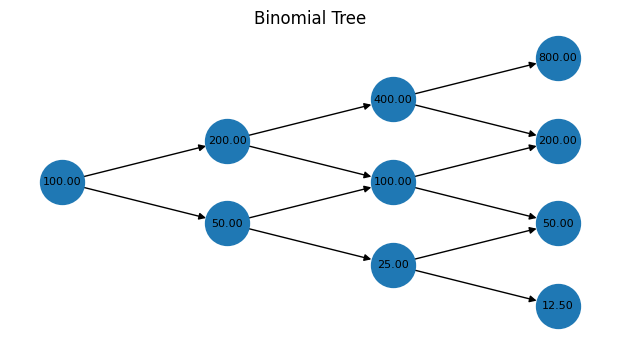

In [210]:
class BinomialTree:
    def __init__(self, S0 : float, u : float, d : float):
        """
        Args:
            S0 : Initial price
            u : Up factor 
            d : downfactor
        """
        
        self.S0 = S0
        self.u = u
        self.d = d
    
    def generate_tree(self, depth : int) -> List[List]:
        """
        Generates tree
        """
        tree = []
        tree.append([self.S0])
        for i in range(1,depth):
            stage = []
            for j in range(i,-1,-1):
                stage.append(self.S0*(self.u**j)*(self.d**(i-j)))
            tree.append(stage)
        return tree

    def display_binomial_tree(self, tree : List[List[float]]):
        G = nx.DiGraph()
        pos = {}
        labels = {}
        
        node_id = 0
        node_map = {} 
        for level, nodes in enumerate(tree):
            for i, value in enumerate(nodes):
                current_node = node_id
                node_map[(level, i)] = current_node
                pos[current_node] = (level, -i + level / 2)
                labels[current_node] = f"{value:.2f}"
                node_id += 1

        for level in range(len(tree) - 1):
            for i in range(len(tree[level])):
                current = node_map[(level, i)]
                down = node_map[(level + 1, i)]
                up = node_map[(level + 1, i + 1)]
                G.add_edge(current, down)
                G.add_edge(current, up)

        plt.figure(figsize=(6, 3))
        nx.draw(G, pos, labels=labels, with_labels=True, node_size=1000, font_size=8)
        plt.title("Binomial Tree")
        plt.axis('off')
        plt.show()
        
S0 = 100
u = 2
d = 0.5
tree = BinomialTree(S0, u, d)
t = tree.generate_tree(4)
tree.display_binomial_tree(t)

In [260]:
class Option:
    def payoff(self, price : float):
        raise NotImplementedError

class EuroCall(Option):
    def __init__(self, strike : float):
        self.strike = strike 
    
    def payoff(self, price : float):
        return max(price-self.strike,0)    

class EuroPut(Option):
    def __init__(self, strike : float):
        self.strike = strike 
    
    def payoff(self, price : float):
        return max(self.strike-price,0)    

class ComboOption(Option):
    def __init__(self, options = List[Option]):
        self.options = options
        
    def payoff(self, price : float):
        payoff = 0
        for op in self.options:
            payoff += op.payoff(price)
        return payoff

class OptionsBinomialPricer:
    def __init__(self, option : Option, up_p : float, down_p : float):
        assert up_p<1 and down_p<1 and up_p > 0 and down_p > 0  and (up_p+down_p)== 1
        self.option = option
        self.up_p = up_p
        self.down_p = down_p
    
    def find_EV(self, tree : List[List]):
        option_values = [self.option.payoff(price) for price in tree[-1]]
        for i in range(len(tree) - 2, -1, -1):
            next_values = []
            for j in range(len(tree[i])):
                expected_value =  self.down_p * option_values[j + 1] + self.up_p * option_values[j]
                next_values.append(expected_value)
            option_values = next_values
        return option_values[0]
    
call = EuroCall(110)
pricer = OptionsBinomialPricer(call,1/3,2/3)
pricer.find_EV(t)

45.55555555555555

### Time complexity of binomial model

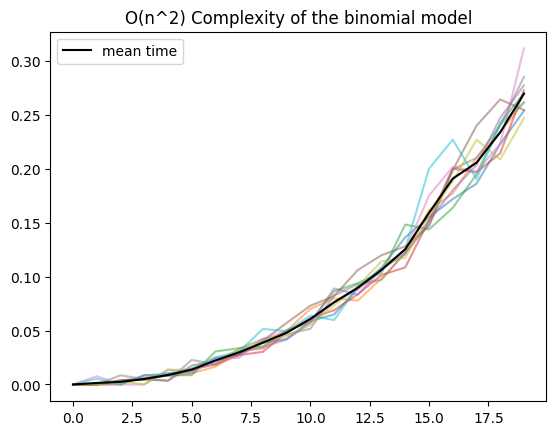

In [247]:
import time
plt.title("O(n^2) Complexity of the binomial model")

S0 = 100
u = 2
d = 0.5
tree = BinomialTree(S0, u, d)
call = EuroCall(110)
pricer = OptionsBinomialPricer(call,0.5,0.5)

mean_time = 0
for _ in range(10):
    times = []
    for i in range(10,1000,50):
        start = time.time()
        pricer.find_EV(tree.generate_tree(i))
        end = time.time()
        times.append(end-start)
    mean_time +=np.array(times)
    plt.plot(times, alpha=0.5)
plt.plot((mean_time/10),color='k', label='mean time')
plt.legend()

## Part 2: Willow Tree Algorithm

The willow tree algorithm proposes that instead of splitting into two extra nodes per node at time t-1, we keep the number of nodes fixed. It is based on the idea that under specific constraints, we can have a markov chain of n nodes which at the limit as n->infinity approaches brownian motion. 

First, we choose n normal variates to represent the normal distribution, $z_1,...,z_n$, and corresponding probabilities $q_1,...,q_n$ where 
$q_i = P(Z=z_i)$, $Z$ a standard normal random variable.

Then we choose our time nodes $t_k$ such that $t_k=\sum_{j=1}^{k}h_i$ where each $h_i > 0$ represents the time steps. Then our markov process if at state $i$ at time $t_k$ will take on the value $\sqrt{t_k}z_i$. At time 0, we start at state $0$, $z_0=0$.

For brownian motion in the limit, we apply the following constraints to the matrix transition matrix $P_k=(p^k)_{ij}$ at time $t_k$
\begin{array}{lr}
\displaystyle  \sum_{j=1}^n{p_{ij}^k} = 1, \forall i & \text{Sum of probabilities is 1} \\
\displaystyle \sum_{j=1}^n{p_{ij}^k\sqrt{t_k+h_k}z_j} = \sqrt{t_k}z_i, \forall i & \text{Conditional Expectation/Markov property}\\
\displaystyle \sum_{j=1}^n{p_{ij}^k(t_k+h_k)z_j^2-t_kz_i^2} = h_k, \forall i & \text{Conditional Variance/Markov property}\\
\displaystyle \sum_{i=1}^n{q_ip_{ij}^k} = q_j, \forall j & \text{Probability of going node j at all times/Stationary process}\\
\displaystyle p_{ij}^k>=0, \forall i,j & \text{Positive probabilities}\\
\end{array}

The paper proposes that to solve for $p_{ij}^k$ quickly, we can solve the following optimization problem.

\begin{array}{rl}
\\
\displaystyle \min_{p_{ij}^k} & \sum_{i,j}{p_{ij}^k|\sqrt{t_k+h_k}z_j-\sqrt{t_k}z_i|^3}
\\
\displaystyle  \text{s.t.} & \sum_{j=1}^n{p_{ij}^k} = 1, \forall i \\
\\
\displaystyle  &\sum_{j=1}^n{p_{ij}^k\sqrt{t_k+h_k}z_j} = \sqrt{t_k}z_i, \forall i \\
\\
\displaystyle  &\sum_{j=1}^n{p_{ij}^k(t_k+h_k)z_j^2-t_kz_i^2} = h_k, \forall i \\
\\
\displaystyle  &\sum_{i=1}^n{q_ip_{ij}^k} = q_j, \forall j \\
\\
\displaystyle  &p_{ij}^k>=0, \forall i,j \\
\end{array}

where our objective function aims to get proper convergence of our probabilities to brownian motion.

For our choice of $z_i$ and $q_i$, we can take $z_i=N^{-1}((i-0.5)/n)$ and $q_i = 1/n$, where $N^{-1}$ represents the inverse of the standard normal cdf. This ensures the mean is $0$. For variance $1$, we choose $\delta$ and adjust $z_1$ by $-\delta$ and $z_n$ by $\delta$ so that $q^Tz = 1$, where $q = {q_1,...,q_n}$ and $z = {z_1^2,...,z_n^2}$

In [248]:
class MarkovSolver:
    def __init__(self,n, times):
        """
        Args:
            n (int) : nodes per layer
            times (List[int]) : list of t_k from k=1 to k=m, m number of steps.
        """
        self.n = n
        
        z = [norm.ppf((i-0.5)/n) for i in range(1,n+1)]
        q = [1/n for i in range(n)]
        
        self.z = self.find_delta(z,q)
        self.q = np.array(q)
        
        self.times = times
    
    def full_markov_chain_info(self):
        probabilities = self.probability_chain()
        times = [0] + self.times
        return times, probabilities
        
    def probability_chain(self):
        """
        constructs all transition probabilities for every time step
        """
        
        chain = []
        chain.append(self.q)
        for k in range(1,len(self.times)):
            chain.append(self.solve_transition_probabilities(k))
        
        return chain
        
    def find_delta(self,z,q):
        """
        We want to solve for delta such that
        r = [(z_1-delta)^2,z_2^2,...,z_{n-1}^2,(z_n+delta)^2]
        q = [q_1,...,q_n]
        q^Tr = 1
        
        This is equivalent to solving the following quadratic:
        
        A*delta^2 + B*delta + C = 0
        where 
        A = q_1 + q_n
        B = -2*q_1*z_1 + 2*q_n*z_n
        C = sum(q_i z_i^2) - 1
        """
        
        A = q[0] + q[-1]
        B = -2*q[0]*z[0]+2*q[-1]*z[-1]
        C = sum([j*i**2 for i,j in zip(z,q)])-1
        
        
        discriminant = np.sqrt(B**2-4*A*C)
        
        delta_1 = (-B + discriminant)/(2*A)
        delta_2 = (-B - discriminant)/(2*A)
        
        delta = min(delta_1,delta_2)
        
        z = np.array(z)
        delta_vec = np.zeros_like(z)
        delta_vec[0] = -delta
        delta_vec[-1] = +delta
        
        return z + delta_vec
        
    def solve_transition_probabilities(self, k):
        """
        Solves the linear programming problem posed for k >= 1.
        """
        
        t_k = self.times[k]
        h_k = self.times[k] - self.times[k-1]
        # if k==0:
        #     h_k=t_k
        
        q = self.q
        z = self.z
        
        z_sq = self.z**2
        n = self.n
        
        # Declaring constraints
        constraints = []
        for i in range(n):
            constraints.append({
                'type': 'eq', 
                'fun': lambda p_flat, i=i: np.sum(p_flat.reshape(n, n)[i]) - 1
            })
        for i in range(n):
            constraints.append({
                'type': 'eq',
                'fun' : lambda p_flat, i=i: np.sqrt(h_k+t_k)*(p_flat.reshape(n,n)[i]@z)-np.sqrt(t_k)*z[i]
            })
        for i in range(n):
            constraints.append({
                'type': 'eq',
                'fun' : lambda p_flat, i=i: (h_k+t_k)*(p_flat.reshape(n,n)[i]@z_sq)-t_k*z_sq[i]-h_k
            })
        for j in range(n):
            constraints.append({
                'type' : 'eq',
                'fun' : lambda p_flat, j=j: q@(p_flat.reshape(n,n)[:,j])-q[j]
            })
        
        # Probability between 0 and 1 constraint
        bounds = [(0, 1)] * (n * n) 
        
        # Broadcasting z and forming the cost matrix
        C = abs(np.sqrt(h_k+t_k)*z[None, :] - np.sqrt(t_k)*z[:, None])**3

        # Defining the objective function
        def objective_func(p_flat):
            p = p_flat.reshape(n, n)
            return np.sum(p*C)

        # Initial guess probability matrix
        p_init = np.full((n, n), 1 / n).flatten()

        result = minimize(
            objective_func,
            p_init,
            # method='trust-constr',
            constraints=constraints,
            bounds=bounds,
        )
        # print(result)
        
        p = result.x.reshape(n,n)
        
        return p

In [249]:
# List of t_1 to t_m. t_0 does not need to be specified.
times = [0.5,1,1.5,2,3,4,5,7,9,12]
msolver = MarkovSolver(10,times)
markov_times, markov_transition = msolver.full_markov_chain_info()

Text(0, 0.5, 'Value of node')

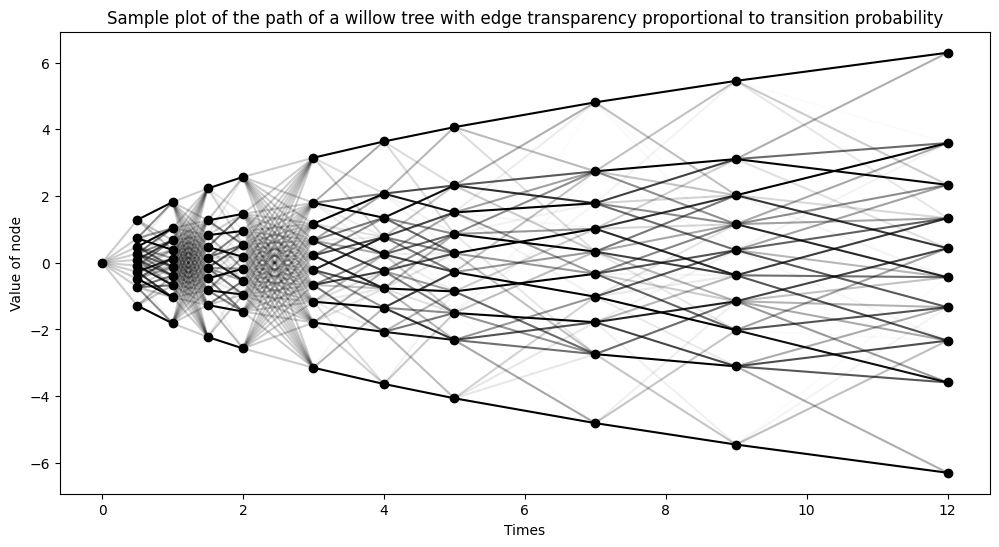

In [250]:
"""
Displaying the willow tree
"""

plt.figure(figsize=(12,6))
plt.title("Sample plot of the path of a willow tree with edge transparency proportional to transition probability")
z_vals = msolver.z
x_vals = [0]
y_vals = [0]
for time in markov_times:
    if time != 0:
        for z in z_vals:
            x_vals.append(time)
            y_vals.append(np.sqrt(time)*z)

for z in z_vals:
    plt.plot([0,markov_times[1]],[0,np.sqrt(markov_times[1])*z],color='k',alpha=min(1,2/len(z_vals)))

for i, (t1, t2) in enumerate(zip(markov_times[1:-1], markov_times[2:])):
    for j,z1 in enumerate(z_vals):
        for k,z2 in enumerate(z_vals):
            plt.plot([t1, t2], [np.sqrt(t1)*z1, np.sqrt(t2)*z2],color='k',alpha=min(1,2*markov_transition[i+1][j,k]))
            

plt.plot(x_vals,y_vals,marker='o',linewidth=0,color='k')
plt.xlabel('Times')
plt.ylabel('Value of node')


Text(0, 0.5, 'Value of node')

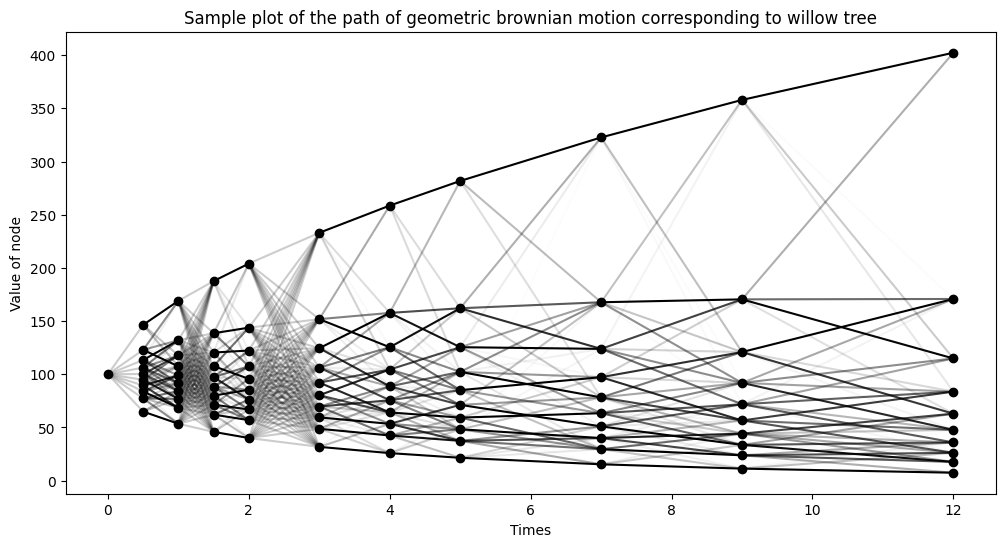

In [251]:
"""
Converting willow tree path into geometric brownian motion path
"""
plt.figure(figsize=(12,6))
plt.title("Sample plot of the path of geometric brownian motion corresponding to willow tree")

S0 = 100
risk_free_rate = 0
volatility = 0.1

z_vals = msolver.z
x_vals = [0]
y_vals = [S0]
for time in markov_times:
    if time != 0:
        for z in z_vals:
            x_vals.append(time)
            
            b_t = np.sqrt(time)*z
            gbm_val = S0*np.exp((risk_free_rate-volatility/2)*time+(np.sqrt(volatility)*b_t))

            y_vals.append(gbm_val)
            
for z in z_vals:
    b_t = np.sqrt(markov_times[1])*z
    gbm_val = S0*np.exp((risk_free_rate-volatility/2)*markov_times[1]+(np.sqrt(volatility)*b_t))
    plt.plot([0,markov_times[1]],[S0,gbm_val],color='k',alpha=min(1,2/len(z_vals)))

for i, (t1, t2) in enumerate(zip(markov_times[1:-1], markov_times[2:])):
    for j,z1 in enumerate(z_vals):
        for k,z2 in enumerate(z_vals):
            coords = []
            
            b_t = np.sqrt(t1)*z1
            gbm_val = S0*np.exp((risk_free_rate-volatility/2)*t1+(np.sqrt(volatility)*b_t))
            coords.append(gbm_val)

            b_t = np.sqrt(t2)*z2
            gbm_val = S0*np.exp((risk_free_rate-volatility/2)*t2+(np.sqrt(volatility)*b_t))
            coords.append(gbm_val)
            
            plt.plot([t1, t2], coords,color='k',alpha=min(1,2*markov_transition[i+1][j,k]))
                        

plt.plot(x_vals, y_vals, marker='o', linewidth=0, color='k')
plt.xlabel('Times')
plt.ylabel('Value of node')


In [252]:
class OptionsWillowPricer:
    def __init__(self, option : Option, risk_free_rate, volatility, S0):
        self.option = option
        self.r = risk_free_rate
        self.volatility = volatility
        self.S0 = S0
        
    def find_EV(self, solver : MarkovSolver):        
        """
        Applying the formula
        V_0 = exp(-rT) * q^T V_T
        
        Note: The product of all the transition matrices ends up reducing to just the q vector
        """
        
        markov_times, markov_transition = solver.full_markov_chain_info()
        terminal_gbm_vals = self.terminal_gbm(solver.z, final_time = markov_times[-1])
        V = np.array([self.option.payoff(i) for i in terminal_gbm_vals])
        return np.exp(-markov_times[-1]*self.r) * (solver.q.T @ V)
        
    def terminal_gbm(self, z_vals, final_time):
        """
        Finds the terminal values of the geometric brownian motion for each final state in Willow tree.
        """
        b_t = np.sqrt(final_time)*z_vals
        return self.S0*np.exp((self.r-self.volatility/2)*final_time + np.sqrt(self.volatility)*b_t)

In [253]:
call = EuroCall(110)
msolver = MarkovSolver(10,[i for i in range(40)])
willowpricer= OptionsWillowPricer(call, risk_free_rate=0, volatility=0.1, S0 = 100)
willowpricer.find_EV(msolver)

np.float64(40.623071850633366)

100%|██████████| 20/20 [01:10<00:00,  3.55s/it]


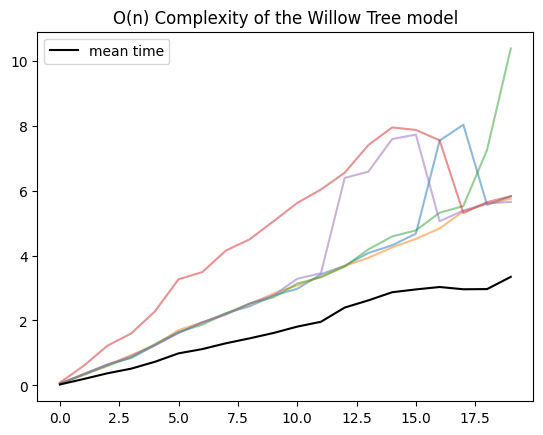

In [254]:
import time
from tqdm import tqdm
plt.title("O(n) Complexity of the Willow Tree model")

S0 = 100
u = 2
d = 0.5
call = EuroCall(110)
pricer = OptionsWillowPricer(call, risk_free_rate=0, volatility=0.1, S0 = 100)
mean_time = 0

for _ in range(5):
    times = []
    for i in tqdm(range(10,1000,50)):
        msolver = MarkovSolver(5,[i for i in range(i)])
        start = time.time()
        pricer.find_EV(msolver)
        end = time.time()
        times.append(end-start)
    mean_time +=np.array(times)
    plt.plot(times, alpha=0.5)
plt.plot((mean_time/10),color='k', label='mean time')
plt.legend()

We can see from the above that the time complexity fo the willow tree is linear with respect to the time steps as compared to the quadratic time complexity of the binomial pricing model.

## Part 3: Comparing error with black scholes

The following code compares the error of the two methods in computing the fair value of a euro call with strike 110 given the same
time to maturity, risk free rate, volatility and starting price S0. We compare their errors as we increase the number of timesteps in each model.

In [ ]:
time_to_maturity = 3
risk_free_rate = 0
sigma = 0.4
S0 = 100
K = 110
call = EuroCall(K)

d1 = (np.log(S0 / K) + (risk_free_rate + 0.5 * sigma**2) * time_to_maturity) / (sigma * np.sqrt(time_to_maturity))
d2 = d1 - sigma * np.sqrt(time_to_maturity)

bscholes_price = S0 * norm.cdf(d1) - K * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2)


binomial_prices = []
willow_prices = []

for time_steps in range(4,1001,100):
    del_t = time_to_maturity/time_steps
    
    # Binomial tree calculation
    u = np.exp(sigma*np.sqrt(del_t))
    d = 1/u
    
    up_probability = (np.exp(risk_free_rate*del_t) - d)/(u-d)
    down_probability = 1-up_probability
    
    tree = BinomialTree(S0, u, d)
    pricer = OptionsBinomialPricer(call,up_probability,down_probability)
    binomial_ev = pricer.find_EV(tree.generate_tree(time_steps)) 
    binomial_prices.append(binomial_ev)

for j in tqdm(range(3,16)):
    # Willow tree calculation
    msolver = MarkovSolver(j,[i/10*time_to_maturity for i in range(1,11)])
    willowpricer= OptionsWillowPricer(call, risk_free_rate, sigma**2, S0)
    willow_ev = willowpricer.find_EV(msolver)
    willow_prices.append(willow_ev)


100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


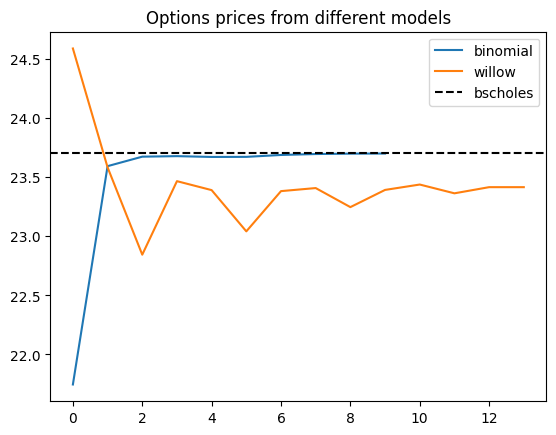

In [268]:
"""
Plot of different options prices
"""
plt.title('Options prices from different models')
plt.plot(binomial_prices, label = 'binomial')
plt.plot(willow_prices, label = 'willow')
plt.axhline(bscholes_price, linestyle='--', color='k', label='bscholes')
plt.legend()